## 1. $H\rightarrow b\bar{b}$ via Machine Learning 

A couple of days ago, we used a neural network to distinguish between handwritten characters. Today, we shall instead use a neural network to distinguish between events that contain a Higgs boson decay (signal) or some background process. 

## 1.1 Neural Networks in Keras

The algorithm for doing the $H\rightarrow b\bar{b}$ can be summarised with the following steps:

* Import libraries and load data.
* Build neural network. 
* Training Neural Network. 
* Make decisions about events using the Neural Network. 
* Calculate sensitivity. 


## 1.2 Importing libraries and loading 

The Keras library is a free open-source tool to quickly and easily develop with neural networks. It does a lot of the heavy lifting for us making it an ideal tool for prototyping. Just like any popular Python library, it is well documented with guides explaining how to use it. These are available here: https://keras.io/

In this exercise, your mentors will guide you through a lot of the code that has already been written for you so that you can focus specifically on building the neural network. It is still valuable to understand what is going on so make sure you ask questions! 

In [1]:
!wget https://raw.githubusercontent.com/nikitapond/in2HEP/master/data-v1/VHbb_data_2jet.csv
!wget https://raw.githubusercontent.com/nikitapond/in2HEP/master/notebooks/ucl_masterclass.py
    
import pandas as pd
from copy import deepcopy
from ucl_masterclass import *
from sklearn.preprocessing import scale
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_yaml
from keras.layers import Input, Dense, Dropout, Flatten
from keras import backend as K
from time import time
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


--2022-07-28 07:42:42--  https://raw.githubusercontent.com/nikitapond/in2HEP/master/data-v1/VHbb_data_2jet.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44311357 (42M) [text/plain]
Saving to: ‘VHbb_data_2jet.csv.5’

VHbb_data_2jet.csv. 100%[===================>]  42.26M  7.68MB/s    in 5.8s    

2022-07-28 07:43:53 (7.31 MB/s) - ‘VHbb_data_2jet.csv.5’ saved [44311357/44311357]

--2022-07-28 07:43:53--  https://raw.githubusercontent.com/nikitapond/in2HEP/master/notebooks/ucl_masterclass.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200

## 1.3 Training and testing dataset

The neural network is given a set of training events that have a Class label of 1 for signal and 0 for background. During the training phase, the neural network goal is to *learn* how to map input variables given to it (kinematic and topological quantities of the event) to 0 for background and 1 for signal. 

To ensure that the neural network is learning general features about the signal and background process and not just **artifacts** unique to the training data set, we split the data set into a training and testing set. We train our model on the training dataset, and evaluate its performance on the testing dataset. We split the dataset in the next couple of code cells.

**In the section below we extract the input (x) and target values (y) used to train the neural network.**

In [3]:
# Define the variables we wish to use
variables = ['dRBB','mBB','MET','Mtop','pTV',]
num_variables = len(variables)

In [4]:
# Load the dataset
df = pd.read_csv('VHbb_data_2jet.csv')

# Define what fraction of the dataset is for testing
test_frac = 0.5

# Split the dataset into a training/testing split
df_train, df_test = train_test_split(df, test_size=test_frac)
df_test = deepcopy(df_test)

# Get the X, Y, and weights for training dataset
X_train = scale(df_train[variables].values)
Y_train = df_train['Class'].values
W_train = df_train['training_weight'].values

# We only need the X_test from the test dataset
X_test = scale(df_test[variables].values)
# Scale event weights by dataset fraction
df_test['EventWeight'] /= test_frac

## 1.4 Training the model
Now our data is ready, we can define our model, and train it.

Epoch 1/5
1842/1842 [==============================] - 2s 1ms/step - loss: 0.5068 - accuracy: 0.7603
Epoch 2/5
1842/1842 [==============================] - 2s 1ms/step - loss: 0.3863 - accuracy: 0.8437
Epoch 3/5
1842/1842 [==============================] - 2s 1ms/step - loss: 0.3631 - accuracy: 0.8564
Epoch 4/5
1842/1842 [==============================] - 2s 1ms/step - loss: 0.3563 - accuracy: 0.8612
Epoch 5/5
1842/1842 [==============================] - 2s 1ms/step - loss: 0.3506 - accuracy: 0.8645
NN sensitivity: 2.05


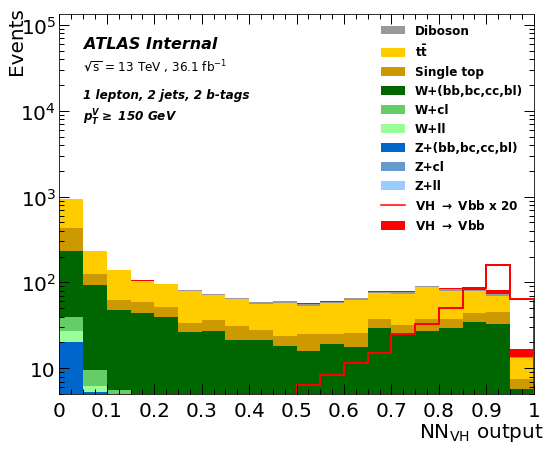

(<Figure size 612x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f18907c0d90>)

In [5]:
model = Sequential([
    # An input layer that has the same size, as number of variables used
  Dense(units=num_variables,input_dim = num_variables,activation='relu'), 
  Dense(16, activation='relu'), # A single hidden layer with 16 neurons
  Dense(1, activation='sigmoid') # An output layer of size 1
])

model.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])
model.fit(X_train, Y_train, sample_weight=W_train, epochs=5, batch_size=32)

df_test['decision_value'] = model.predict(X_test)
print(f"NN sensitivity: {round(sensitivity_NN(df_test)[0],2)}")
nn_output_plot(df_test)

We already get a good sensitivity compared to the cut based approach attempted yesterday.

### Task 1 - Sensitivity variance
Try running the two code cells above a few times (creating the model, and evaluting its sensitivity, add each sensitivity to the list below), what do you notice?

In [ ]:
# Add your sensitivities here
sensitivities = []

# Turn list into numpy array for better scientific use
sensitivities = np.array(sensitivities)

# Find mean and standard deviation of sensitivity
mean = round(np.mean(sensitivities),3)
std = round(np.std(sensitivities),3)

print(f"The average sensitivity was {mean} +- {std}")

As in all experiments, the outcome will change a little bit every time. In a physical experiment, this might be due to slight measurement errors, or fluctuations in the environment. In a machine learning model, it is due to the way the model learns, which has some random elements to it. This results in slightly different outputs for the model each time we train it.
To get a better idea of if 1 model is actually better than another, we can train a model multiple times and take an average of the result.

We could do this in a new cell, and write a for loop and take an average. Instead, we introduce a function below that uses a function to build the model, and then automatically trains it several times and returns the average sensitivity.



In [6]:
def CalculateAverageSensitivity(classifier, epochs, batchsize, iterations=3):
    '''
    Creates and trains a model multiple times, calculates the average sensitivity, and 
    the standard deviation in the sensitivity
    
    Parameters:
        classifier - a function the returns a tensorflow model
        epochs - the number of epochs to train for
        batchsize - the batchsize per epoch
        iterations - the number of models to train and take an average of
    Returns - mean, std
        mean - the mean average sensitivity
        std - the standard deviation in the sensitivity
    '''
    
    results = []
    for i in range(iterations):
        model = classifier()
        model.fit(X_train, Y_train, sample_weight=W_train, epochs=5, batch_size=32, verbose=0)
        df_test['decision_value'] = model.predict(X_test)
        sense  = round(sensitivity_NN(df_test)[0],3)
        print(f"Model {i} finished training with sensitivity {sense}")
        results.append(sense)
    
    results = np.array(results)
    return np.mean(results), np.std(results)

In [7]:
# Define architecture 
def classifier():
    """
    Creates a model for higgs to bb classification
    
    returns: Keras model
    """
    
    model = Sequential([
    # An input layer that has the same size, as number of variables used
      Dense(units=num_variables,input_dim = num_variables,activation='relu'), 
      Dense(16, activation='relu'), # A single hidden layer with 16 neurons
      Dense(1, activation='sigmoid') 
    ])

    model.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])
    return model

In [8]:
mean, std = CalculateAverageSensitivity(classifier, 5, 32)
print(f"\nThe model sensitivity was {round(mean,2)} +- {round(std,2)}")

Model 0 finished training with sensitivity 1.961
Model 1 finished training with sensitivity 1.591
Model 2 finished training with sensitivity 2.016

The model sensitivity was 1.86 +- 0.19


### Task 2 - Improve the model
Now that we can easily find the average sensitivity, we can try and improve our model. Below, we write another classifier function that creates a new model. Try changing some of the following parameters to try and improve performance:
* Number of hidden layers
* Number of neurons in hidden layers
* Activation function in hidden layers
* Optimizer function
* Number of epochs
* Batch size

Write down the variables you changed, and the sensitivity, in the following code cell, so you can plot your results.

If you're confident with this already, you can try a for loop based approach for testing different parameters, as was shown in the final task of the MNIST neural network a couple of days ago.

In [9]:
# Define architecture 
def classifier():
    """
    Creates a model for higgs to bb classification
    
    returns: Keras model
    """
    
    model = Sequential([
    # An input layer that has the same size, as number of variables used
      Dense(units=num_variables,input_dim = num_variables,activation='relu'), 
      Dense(16, activation='relu'), # A single hidden layer with 16 neurons
      Dense(1, activation='sigmoid') # An output layer of size 10, for the 10 possible digits
    ])

    model.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])
    return model

epochs = 5
batchsize = 32

mean, std = CalculateAverageSensitivity(classifier, epochs, batchsize)
print(f"\nThe model sensitivity was {round(mean,2)} +- {round(std,2)}")

Model 0 finished training with sensitivity 1.936
Model 1 finished training with sensitivity 2.013
Model 2 finished training with sensitivity 2.085

The model sensitivity was 2.01 +- 0.06


In [ ]:
var_changed = [0, 1, 2, 3]
sensitivity = [7,3,4,1]

plt.plot(var_changed, sensitivity)
# Add a title, and axis labels



# save the figure to pdf - change the name so you don't overwrite your plots!
plt.savefig("atlas_sense_plot.png")

## Task 4 - Importance of each variable
* We have so far given 5 variables to use during training ('dRBB','mBB','MET','Mtop','pTV'). Try instead training on only 1 or two variables. Which variable/variable pair is most important when training? 

In [ ]:
# Use only 1 or two variables, what sensitivity do you achieve?
variables = ['dRBB']
num_variables = len(variables)

# Load the dataset
df = pd.read_csv('VHbb_data_2jet.csv')

# Define what fraction of the dataset is for testing
test_frac = 0.5

# Split the dataset into a training/testing split
df_train, df_test = train_test_split(df, test_size=test_frac)
df_test = deepcopy(df_test)

# Get the X, Y, and weights for training dataset
X_train = scale(df_train[variables].values)
Y_train = df_train['Class'].values
W_train = df_train['training_weight'].values

# We only need the X_test from the test dataset
X_test = scale(df_test[variables].values)
# Scale event weights by dataset fraction
df_test['EventWeight'] /= test_frac

In [ ]:
var_used = ["dRBB", 'MET', 'dRBB + MET']
sensitivity = [2.1, 2.0, 2.3]

plt.bar(var_used, sensitivity)

# Add a title, and axis labels.
# If you forgot how, check the notebooks from previous days
# Or try googling, and using the MatPlotLib documentation


<BarContainer object of 3 artists>

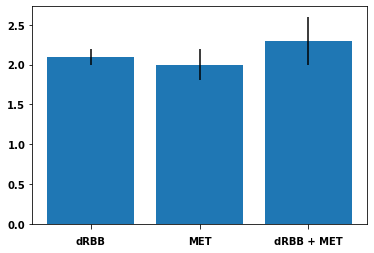

In [10]:
var_used = ["dRBB", 'MET', 'dRBB + MET']
sensitivity = [2.1, 2.0, 2.3]
# The error in our sensitivity (std) used for error bar
standard_deviation = [0.1, 0.2, 0.3] 

# Now we include 'yerr', the y-error. We pass the standard
# deviation returned by the 'CalculateAverageSensitivity' function
plt.bar(var_used, sensitivity, yerr=standard_deviation)

# Add a title, and axis labels.
# If you forgot how, check the notebooks from previous days
# Or try googling, and using the MatPlotLib documentation

## Summary 

Neural Networks can learn correlations between variables and create a better understanding of the classification process hence leading to better signal sensitivity. They have been very popular in industry and regularly win competitions on the Kaggle machine learning forum. If you are interested in doing more machine learning this is a free 'nanodegree' on deep learning: https://www.youtube.com/watch?v=vOppzHpvTiQ&list=PL2-dafEMk2A7YdKv4XfKpfbTH5z6rEEj3

**This material was produced by hackingEducation**  
<img src="images/logo-black.png" width="50" align = 'left'/>
